## Imports

In [61]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import sem, t
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

## Genotype & Phenotype Simulation

In [5]:
#Simulate Genotype
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    
    assert(len(G) == samples_n)
    assert(len(G[0])== loci_m)
    return G

G = simulate_genotype(10,5)

Data with input dtype int32 was converted to float64 by the scale function.


### Set beta and envi noise

In [54]:
#Provide beta_g, e_noise and get G with genotype & Phenotype data
def simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    b_i = beta_g
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a e_j(noise) value
        e_j = e_noise
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    G = np.append(G, Y_n, axis=1)
    return G, loci

#Provide var_g, var_e and get G with genotype & Phenotype data
def simulate_genotype_and_phenotype_var(samples_n, loci_m,var_g,var_e):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G, loci

# Machine Learning Models

## Random Forest Regression & SHAP 

In [46]:
def shap_RFR(G):
    X = G[:,0:len(G[0])-2]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
    forReg.fit(x_train, y_train)
    
    shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
    return shap_values, x_train

def shap_feature_plot_RFR(shap_values, x_train):
    shap.summary_plot(shap_values, x_train, plot_type="bar")

## Calculate SHAP

In [38]:
def mean_shap_values(shap_values):
    if len(shap_values) == 2:
        mean_shap = [0] * len(shap_values[0][0])
        for shap_value in shap_values[0]:
            #print(shap_value)
            for x in range(0, len(shap_value)):
                mean_shap[x] = mean_shap[x] + abs(shap_value[x])
        for x in range(0, len(shap_values[0])):
            mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
    else:    
        mean_shap = [0] * len(shap_values[0])
        for shap_value in shap_values:
            for x in range(0, len(shap_value)):
                mean_shap[x] = mean_shap[x] + abs(shap_value[x])
        for x in range(0, len(shap_values[0])):
            mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
    return mean_shap                   

def max_mean_feature(shap_values):
    mean_shap = mean_shap_values(shap_values)
    return mean_shap.index(max(mean_shap)), mean_shap[mean_shap.index(max(mean_shap))]


## Calculating Accuracy

In [65]:
def shap_acc_RFR_set(samples_n, loci_m, beta_g, e_noise, number_trials):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_set(samples_n, loci_m,beta_g,e_noise)
        shap_values_holder, x_train = shap_RFR(G)
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            shap_values_SNP.append(0)
        counter += 1
    
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    confidence_int = 1
    return percent, confidence_int
    

def shap_acc_RFR_var(samples_n, loci_m, var_g, var_e, number_trials):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype_var(samples_n,loci_m, var_g , var_e)
        shap_values_holder, x_train = shap_RFR(G)
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            shap_values_SNP.append(0)
        counter += 1
    percent = sum(shap_values_SNP) / len(shap_values_SNP) * 100
    confidence_int = 1
    return percent, confidence_int
   

## Graphing

In [82]:
#Line Plots
def plot_shap_values_RFR_line(samples_n, loci_m, range_values, e_val, number_trials, data_type = 'set'):
    
    increment = 1/range_values
    holderg = 0
    g_vals = [0]
    
    for x in range(1, range_values):
        g_vals.append(holderg + increment)
        holderg = holderg + increment
    
    shap_values_SNP = []
    
    if data_type == 'set':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)
    elif data_type == 'var':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)

            
    plt.plot(g_vals, shap_values_SNP) 
    
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
    plt.show()

In [89]:
#Bar Plots
def plot_shap_values_RFR_bar(samples_n, loci_m, range_values, e_val, number_trials, data_type = 'set'):
    
    increment = 1/range_values
    print(increment)

    holderg = 0
    g_vals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    #for x in range(1, range_values):
    #    g_vals.append(holderg + increment)
    #    holderg = holderg + increment
    #    print(holderg)
    
    shap_values_SNP = []
    error = []
    if data_type == 'set':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_set(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)
            error.append(confidence_int)
    elif data_type == 'var':
        for x in range(0,range_values):
            percent, confidence_int = shap_acc_RFR_var(samples_n, loci_m, g_vals[x], e_val, number_trials)
            shap_values_SNP.append(percent)
            error.append(confidence_int)

    # The x position of bars
    barWidth = 0.7
    r1 = np.arange(len(shap_values_SNP))
    r2 = [x + barWidth for x in r1]
    
    bars = g_vals
    x_pos = np.arange(len(bars))
 
    # Create blue bars
    plt.bar(r1, shap_values_SNP, width = barWidth, color = 'blue', edgecolor = 'black', yerr=error, capsize=7)

    # general layout
    print(g_vals)
    plt.xticks(x_pos, g_vals)
    plt.ylabel('Percent accuracy of feature selection')

    plt.plot(g_vals, shap_values_SNP) 
    
 
    if data_type == 'set':
        plt.xlabel('Value of Genetic Effect')
        plt.title('Effect of Genetic Effect on SHAP Accuracy in Feature Selection') 
    elif data_type == 'var':
        plt.xlabel('Variance of Genetic Effect')
        plt.title('Effect of Variance Genetic Effect on SHAP Accuracy in Feature Selection') 
        
    plt.show()

0.1
[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


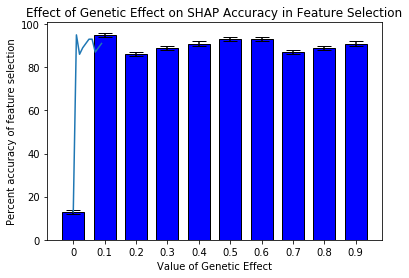

In [90]:
#Testing
samples_n = 100
loci_m = 10
range_values = 10
e_val = 0
number_trials = 100
'''
beta_g = 0.9
e_noise = 0.1
G, loci = simulate_genotype_and_phenotype_abs(samples_n, loci_m,beta_g,e_noise)
print(loci)
shap_values, x_train = shap_RFR(G)
shap_feature_plot_RFR(shap_values, x_train)
print(mean_shap_values(shap_values))
print(max_mean_feature(shap_values))
'''
plot_shap_values_RFR_bar(samples_n, loci_m, range_values, e_val, number_trials, data_type = 'set')
#plot_shap_values_RFR(samples_n, loci_m, range_values, e_val, number_trails, data_type = 'set')
#plot_shap_values_RFR(samples_n, loci_m, range_values, e_val, number_trails, 'var')